### Setup and Load Data ###

In [1]:
run ../initialize.ipynb

Lax Version : 1.5.2


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/seaborn-0.8.1-py3.4.egg/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
mpl.rcParams['axes.linewidth'] = 2.5
R_tpc=pax_config['DEFAULT']['tpc_radius']

In [3]:
def get_file_list(path, pattern, remove_string='', remove_path=True):
    '''
    Get a list of files matching pattern in path. Optional to remove a part of the path (i.e. the extention)
    Optional to remove the path
    '''
    file_list = glob.glob(path + pattern)
    # Remove path
    for i, f in enumerate(file_list):
        if remove_path:
            f = f.replace(path, '')
        if remove_string != '':
            f = f.replace(remove_string, '')
        file_list[i] = f
    file_list = np.sort(file_list)
    return file_list


### Extract Hist from pr processed pickles

In [4]:
datasets = hax.runs.datasets 
datasets = hax.runs.tags_selection(include=['*sciencerun1'],
                                  exclude=['bad','messy', 'test',
                                           'nofield','lowfield',
                                           'commissioning', 'flash',
                                           'pmttrip','trip','_pmttrip',
                                           'source_opening',
                                           ],
                                  )
datasets= hax.cuts.selection(datasets, datasets['location'] != '', 'Processed data available')

#Radon
datasets_rn = hax.cuts.selection(datasets, datasets['source__type']=='Rn220', 'Source in place')
dataset_names_rn = datasets_rn['name']

#Bkg
datasets_bkg = hax.cuts.selection(datasets, datasets['source__type']=='none', 'Source in place')
dataset_names_bkg = datasets_bkg['name']

#Krypton
datasets_kr = hax.cuts.selection(datasets, datasets['source__type']=='Kr83m', 'Source in place')
dataset_names_kr = datasets_kr['name']

Processed data available selection: 0 rows removed (100.00% passed)
Source in place selection: 7229 rows removed (4.56% passed)
Source in place selection: 1185 rows removed (84.35% passed)
Source in place selection: 7119 rows removed (6.01% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/cuts.py:125: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [5]:
%%time
print('Radon Data')
#simpath= '/home/jpienaar/Test_files/'
simpath= '/scratch/midway2/jpienaar/cache_files/'

#Find datasets
datasets = get_file_list(simpath, '*random_dt.pkl', ' ')
print('Found %d datasets' % len(datasets))
n_files=len(datasets)

dicts_datasets_rn={}
dicts_datasets_kr={}
dicts_datasets_bkg={}
for dataset in tqdm(datasets[:]):
    key=dataset[:-7]
    if dataset_names_rn.isin([dataset[:-14]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
        dicts_datasets_rn[key]=data_dict
              
    elif dataset_names_kr.isin([dataset[:-14]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
        dicts_datasets_kr[key]=data_dict
        
    elif dataset_names_bkg.isin([dataset[:-14]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
        dicts_datasets_bkg[key]=data_dict
    
#df_PI=pd.concat(df_PI)

  0%|          | 0/1016 [00:00<?, ?it/s]

Radon Data
Found 1016 datasets


100%|██████████| 1016/1016 [00:22<00:00, 44.64it/s]

CPU times: user 2.69 s, sys: 271 ms, total: 2.96 s
Wall time: 22.8 s


In [6]:
dict_source={'Radon' : dicts_datasets_rn, 'Background' : dicts_datasets_bkg}
for source, dict_data in dict_source.items():
    print(source, len(dict_data))

Radon 33
Background 972


In [7]:
# Plots average lifetime over a run, versus run number

#plt.figure(figsize=(10, 8))
source_key={'Radon': 'Rn220', 'Krypton': 'Kr83m', 'Background': 'none'}
colours=['blue', 'orange', 'green']
index=0
_xmax=10**8
_tpoints=np.linspace(0, _xmax, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
livet_hist=0
events=0
source_dfs={}
for source, dict_data in dict_source.items():
    print(source)
    #plt.figure(figsize=(10, 8))
    
    average_array=[]
    datasets_array=[]
    
    datasets = hax.runs.datasets
    datasets_source = hax.cuts.selection(datasets, datasets['source__type']==source_key[source], 'Source in place')

    for key, data in tqdm(dict_data.items()):
        livet_hist
        livet_hist=data['livet_hist']
        events=data['events']

        #new_hist=livet_hist.sum('s2_area')
        new_hist=livet_hist/events
            
        average_array.append(np.average(new_hist[:]))
        datasets_array.append(key)
        
    source_datasets=datasets.loc[datasets.name.isin(datasets_array)]
    assert len(average_array)==len(source_datasets)
    source_datasets['average_livetime']=average_array
    test_df=pd.DataFrame({'name': datasets_array, 'average': average_array})
    test_df=pd.merge(source_datasets, test_df, on='name', how='outer')
                
    #plt.xlabel('Time Since S2 [ns]', fontsize=12)
    #plt.ylabel('Live Time Fraction [/bin]', fontsize=12)
    #plt.xlim([_xmin, _xmax])
    #plt.savefig("fig_%s_reduced_livet.png" %source, bboxes='tight')
    #plt.savefig("fig_%s_reduced_livet.pdf" %source, bboxes='tight')
    #plt.show()
    
    source_dfs[source]=test_df

plt.figure(figsize=(10, 8))
index=0
for key, df in source_dfs.items():
    plt.plot(df['start'], df['average_livetime'], marker='o', linewidth=0, color=colours[index], label=key)
    index+=1
plt.xlabel('Date', fontsize=12)
plt.legend(loc='best')
plt.ylabel('Average Live Time Fraction', fontsize=12)
plt.xticks(rotation='vertical')
#plt.savefig("fig_date_livet.png", bboxes='tight')
#plt.savefig("fig_date_livet.pdf", bboxes='tight')
plt.show()


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/cuts.py:125: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]
100%|██████████| 33/33 [00:00<00:00, 5058.18it/s]


Radon
Source in place selection: 18797 rows removed (7.01% passed)


AssertionError: 

Radon
1006610
Background
3965776


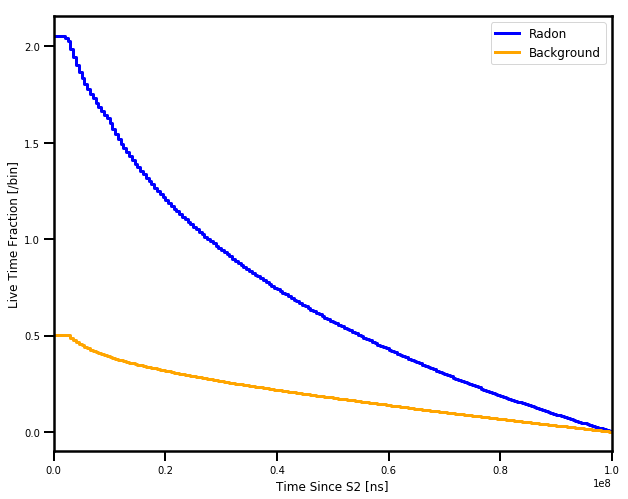

In [9]:
#Plots Live Time Fraction#

plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green']
index=0
_xmax=10**8
_tpoints=np.linspace(0, _xmax, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
plt.set_cmap("Blues")
for source, dict_data in dict_source.items():
    print(source)
    del events_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['livet_hist']
            events+=data['events']
        except NameError:
            events_hist=data['livet_hist']
            events=data['events']
        except KeyError:
            print(source, key)
    
    #events_hist=events_hist.sum('s2_area')
    events_hist=events_hist

       
    #Plot
    plt.step(_tpoints[1:], events_hist/events, linewidth=3,  color=colours[index], label=source)
    index+=1
    
    print(events)


plt.xlim([0, _xmax])
plt.xlabel('Time Since S2 [ns]', fontsize=12)
plt.ylabel('Live Time Fraction [/bin]', fontsize=12)
axes = plt.gca()
axes.tick_params(width=2, length=10)
plt.legend(loc='best', fontsize=12)
plt.savefig("fig_livet_example.png", bboxes='tight')
plt.savefig("fig_livet_example.pdf", bboxes='tight')
#plt.yscale('log')
plt.show()

Radon
1006610
Background
3965776


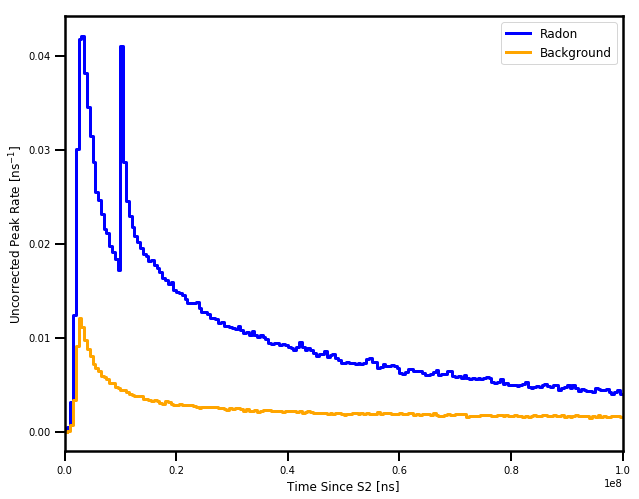

In [10]:
#Plots uncorrected event with error added#

plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green']
index=0
window_length=10**8
_tpoints=np.linspace(0, window_length, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
index=0
plt.set_cmap("Blues")
for source, dict_data in dict_source.items():
    print(source)
    del events_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            events+=data['events']
        except NameError:
            events_hist=data['deltat']
            events=data['events']
        except KeyError:
            print(source, key)
        

    events_hist=events_hist


        
    #Plot
    plt.step(_tpoints[1:], events_hist/events, linewidth=3,  color=colours[index], label=source)
    index+=1
    
    print(events)

plt.xlim([0, window_length])
plt.xlabel('Time Since S2 [ns]', fontsize=12)
plt.ylabel('Uncorrected Peak Rate [ns$^{-1}$]', fontsize=12)
axes = plt.gca()
axes.tick_params(width=2, length=10)
plt.legend(loc='best', fontsize=12)
#plt.savefig("fig_deltat_example.png", bboxes='tight')
#plt.savefig("fig_deltat_example.pdf", bboxes='tight')
#plt.yscale('log')
plt.show()

Background
3965776
Radon
471841


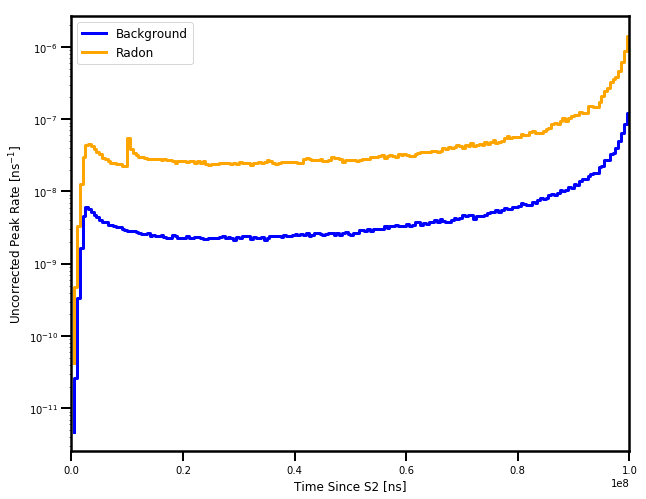

In [23]:
#Plots uncorrected event with error added#

plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green']
index=0
window_length=10**8
_tpoints=np.linspace(0, window_length, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
index=0
plt.set_cmap("Blues")
for source, dict_data in dict_source.items():
    print(source)
    del events_hist
    del livet_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            livet_hist+=data['livet_hist']
            events+=data['events']
        except NameError:
            events_hist=data['deltat']
            livet_hist=data['livet_hist']
            events=data['events']
        except KeyError:
            print(source, key)
        

    events_hist=events_hist/livet_hist


        
    #Plot
    plt.step(_tpoints[1:], events_hist/events, linewidth=3,  color=colours[index], label=source)
    index+=1
    
    print(events)

plt.xlim([0, window_length])
plt.xlabel('Time Since S2 [ns]', fontsize=12)
plt.ylabel('Uncorrected Peak Rate [ns$^{-1}$]', fontsize=12)
axes = plt.gca()
axes.tick_params(width=2, length=10)
plt.legend(loc='best', fontsize=12)
#plt.savefig("fig_deltat_example.png", bboxes='tight')
#plt.savefig("fig_deltat_example.pdf", bboxes='tight')
plt.yscale('log')
plt.show()

Background 1969


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in double_scalars
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars


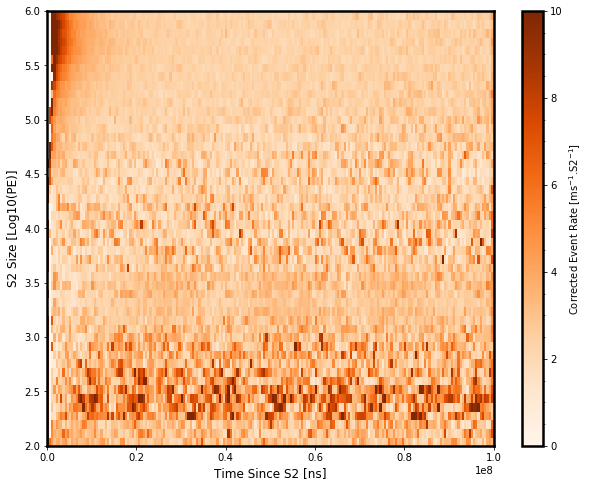

Krypton 103


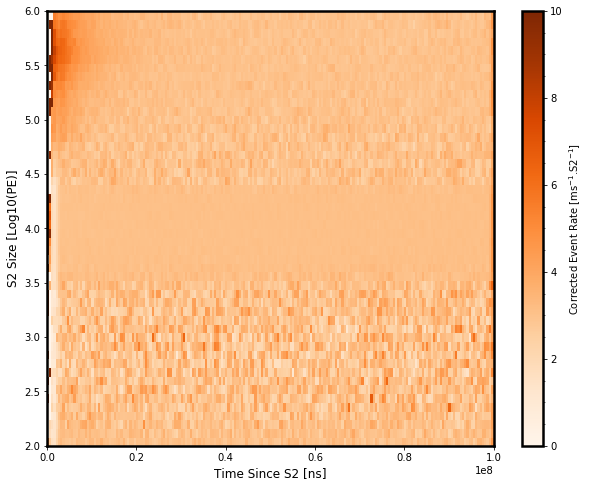

Radon 200


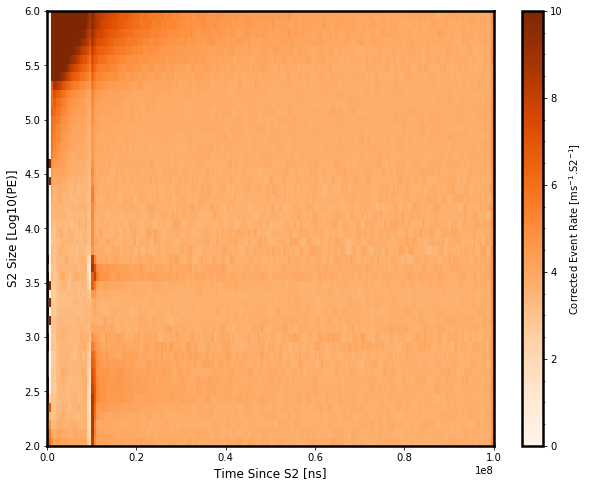

In [32]:
##Live Time Corrected 2d Plots##

#plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green']
index=0
_xmax=10**8
_tpoints=np.linspace(0, _xmax, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
livet_hist=0
events=0
plt.set_cmap("Oranges")

_s2bins=50
_tbins=200
for source, dict_data in dict_source.items():
    print(source, len(dict_data))
    plt.figure(figsize=(10, 8))
    del events_hist
    del livet_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            livet_hist+=data['livet_hist']
            events+=data['events']
        except NameError:
            events_hist=data['deltat']
            livet_hist=data['livet_hist']
            events=data['events']
    
    
    blank_hist=events_hist.similar_blank_histogram()
    for idt in range(_tbins):
        for ids2 in range (_s2bins):
            #blank_hist[idt][ids2]=
            bin_content=events_hist[idt][ids2]/livet_hist[idt][ids2]
            if np.isnan(bin_content):
                blank_hist[idt][ids2]=0
            else:
                blank_hist[idt][ids2]=bin_content
    
    blank_hist=blank_hist*10**6 #ms adjustment
    blank_hist.plot(cblabel = 'Corrected Event Rate [ms$^{-1}$.S2$^{-1}$]', vmax=1*10**1, vmin =0)
    plt.xlabel('Time Since S2 [ns]', fontsize=12)
    plt.ylabel('S2 Size [Log10(PE)]', fontsize=12)
    #plt.savefig("fig_%s_2d_rate_corrected.png" %source, bboxes='tight')
    #plt.savefig("fig_%s_2d_rate_corrected.pdf" %source, bboxes='tight')
    plt.show()    

   
    #new_hist.plot(label=source, color=colours[index])
    #index+=1


Background


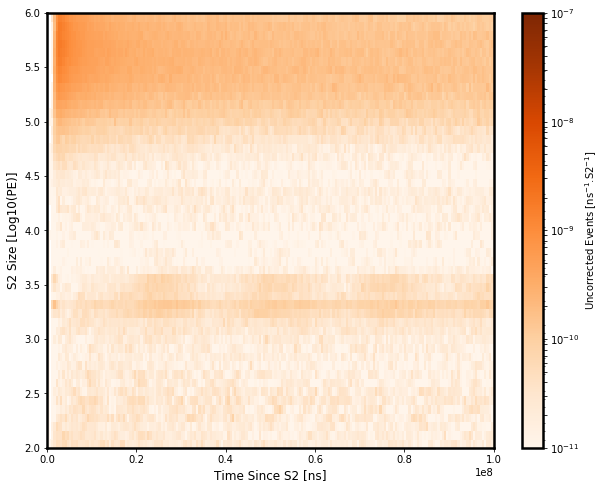

Krypton


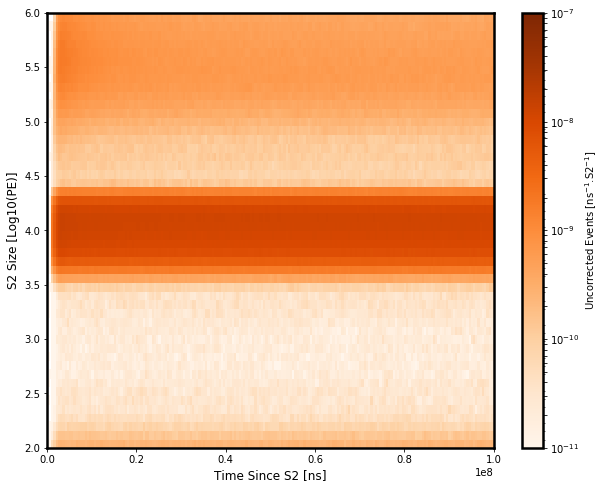

Radon


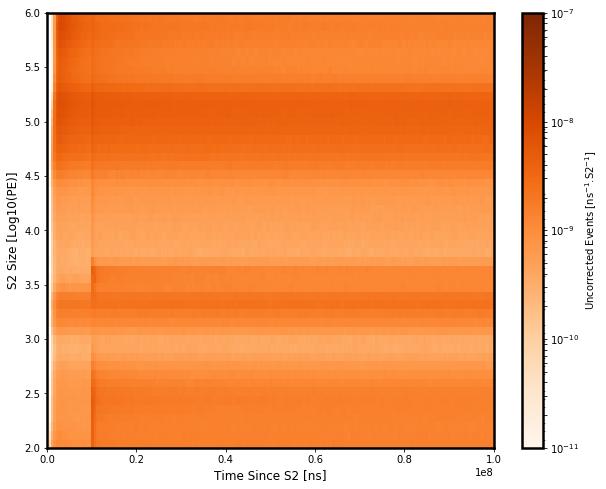

In [34]:
#plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green']
index=0
_xmax=10**8
_tpoints=np.linspace(0, _xmax, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
plt.set_cmap("Oranges")
for source, dict_data in dict_source.items():
    print(source)
    plt.figure(figsize=(10, 8))
    del events_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            events+=data['events']
        except NameError:
            events_hist=data['deltat']
            events=data['events']
    
    new_hist=events_hist/events
    new_hist.plot(cblabel = 'Uncorrected Events [ns$^{-1}$.S2$^{-1}$]', norm=LogNorm(), vmin=10**-11, vmax=10**-7)
    plt.xlabel('Time Since S2 [ns]', fontsize=12)
    plt.ylabel('S2 Size [Log10(PE)]', fontsize=12)
    #plt.savefig("fig_%s_2d_rate.png" %source, bboxes='tight')
    #plt.savefig("fig_%s_2d_rate.pdf" %source, bboxes='tight')
    plt.show()    

   
    #new_hist.plot(label=source, color=colours[index])
    #index+=1


Background


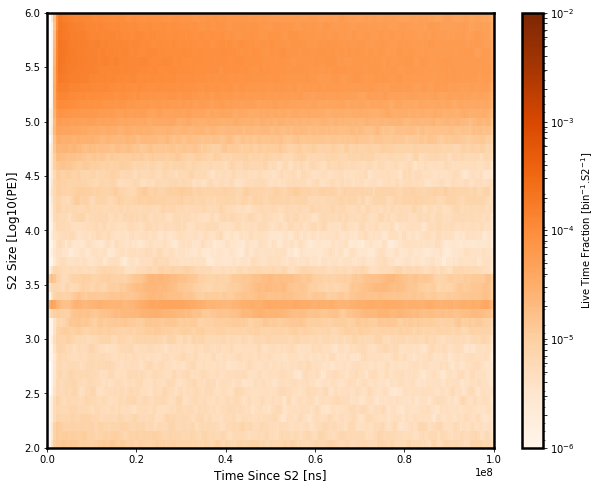

Krypton


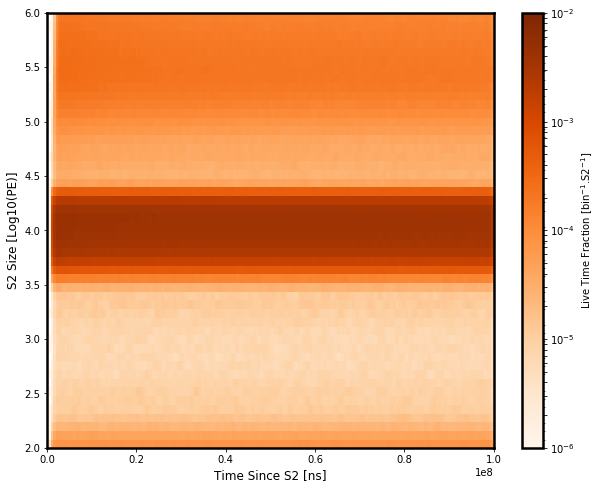

Radon


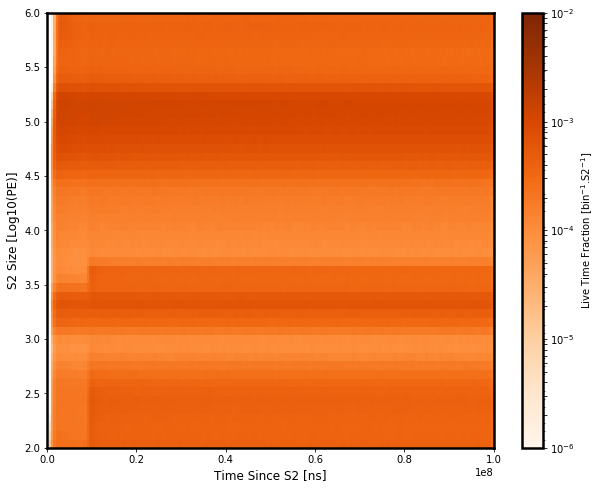

In [36]:
#plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green']
index=0
_xmax=10**8
_tpoints=np.linspace(0, _xmax, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
plt.set_cmap("Oranges")
for source, dict_data in dict_source.items():
    print(source)
    plt.figure(figsize=(10, 8))
    del events_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['livet_hist']
            events+=data['events']
        except NameError:
            events_hist=data['livet_hist']
            events=data['events']
    
    new_hist=events_hist/events
    new_hist.plot(cblabel = 'Live Time Fraction [bin$^{-1}$.S2$^{-1}$]', norm=LogNorm(), vmin=10**-6, vmax=10**-2)
    plt.xlabel('Time Since S2 [ns]', fontsize=12)
    plt.ylabel('S2 Size [Log10(PE)]', fontsize=12)
    #plt.savefig("fig_%s_2d_livetime.png" %source, bboxes='tight')
    #plt.savefig("fig_%s_2d_livetime.pdf" %source, bboxes='tight')
    plt.show()    

   
    #new_hist.plot(label=source, color=colours[index])
    #index+=1


Background


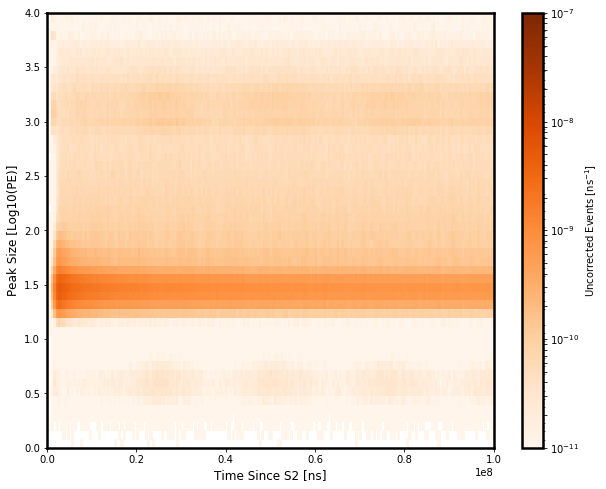

Krypton


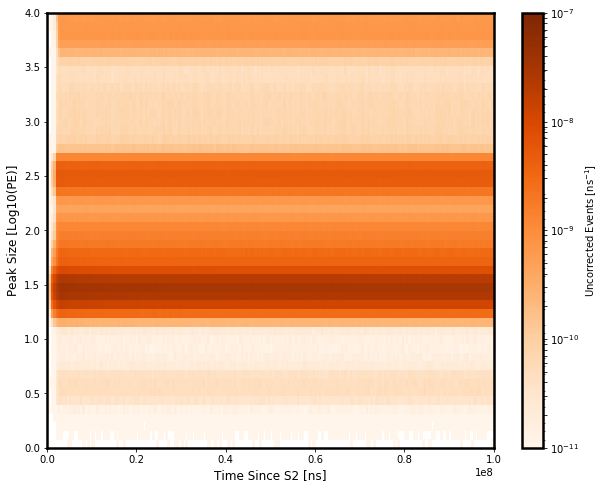

Radon


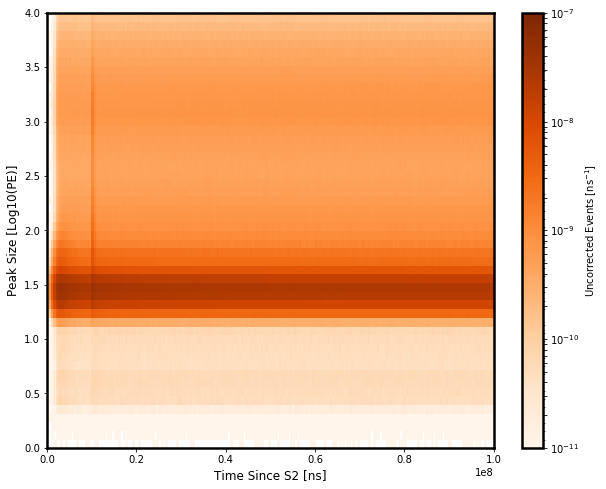

In [37]:
#plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green']
index=0
_xmax=10**8
_tpoints=np.linspace(0, _xmax, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
peaks_hist=0
events=0
for source, dict_data in dict_source.items():
    print(source)
    plt.figure(figsize=(10, 8))
    del peaks_hist
    events=0
    for key, data in dict_data.items():
        try:
            peaks_hist
            peaks_hist+=data['peaks']
            events+=data['events']
        except NameError:
            peaks_hist=data['peaks']
            events=data['events']
    
    new_hist=peaks_hist/events
    new_hist.plot(cblabel = 'Uncorrected Events [ns$^{-1}$]' ,norm=LogNorm(), vmin=10**-11, vmax=10**-7)
    plt.xlabel('Time Since S2 [ns]', fontsize=12)
    plt.ylabel('Peak Size [Log10(PE)]', fontsize=12)
    #plt.savefig("fig_%s_2d_peaks.png" %source, bboxes='tight')
    #plt.savefig("fig_%s_2d_peaks.pdf" %source, bboxes='tight')
    plt.show()    

   


### Position Correlation Stuff

Background 1969


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


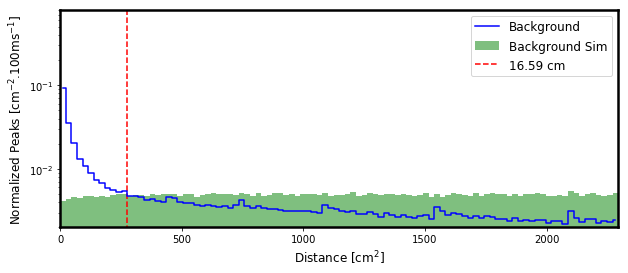

Krypton 103


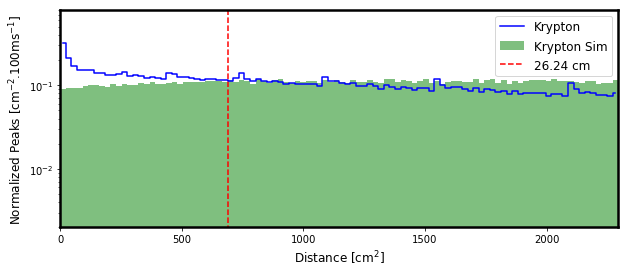

Radon 200


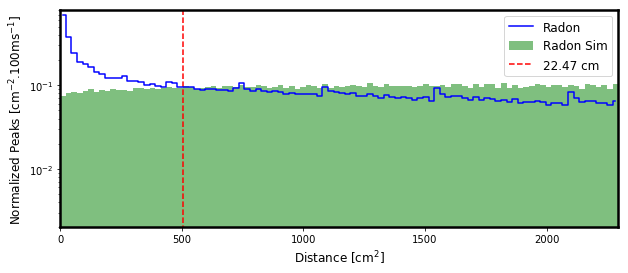

In [70]:
#plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green', 'red', 'magenta', 'cyan']
index=0
_ymin=2*10**-3
_xmax=(47.9)**2
_rpoints=np.linspace(0, (R_tpc)**2, 101)
_ymax=0.8*10**0
r2_hist=0
for source, dict_data in dict_source.items():
    plt.figure(figsize=(10, 4))
    print(source, len(dict_data))
    del r2_hist
    events=0
    for key, data in dict_data.items():
        #print(key)
        try:
            r2_hist
            r2_hist+=data['dt_r2']
            events+=data['events']
        except NameError:
            r2_hist = data['dt_r2']
            events=data['events']
      
    new_hist=r2_hist
    new_hist=new_hist/events
    new_hist=new_hist.sum('delta_T')
    new_hist.plot(label=source, color='blue')
    
    random_comp = dfs_source_distrib_hist[source]['alpha']
    r_norms = dfs_source_distrib_hist[source]['r_norms']

    content, bins = np.histogram(random_comp[:, 0]**2, weights=1/r_norms, bins=100, range=[0, (R_tpc)**2])
    scaling_factor=np.sum(new_hist[:])/np.sum(content)
    plt.hist(random_comp[:, 0]**2, weights=scaling_factor/r_norms, range=[0, (R_tpc)**2], bins=100, 
             histtype='stepfilled', linewidth=2, label='%s Sim' %source, color='green', alpha=0.5)
    #print(np.nansum(random_comp[:,0]**2/r_norms))
    
    
    #event_max=np.max(new_hist)
    #plt.hlines(0.1*event_max, 0, _xmax, color=colours[index], linestyle=":")
   
    idx=1
    for bin_value in new_hist[1:]:
        if bin_value<(content[idx]*scaling_factor):
            plt.vlines(_rpoints[idx], 0, _ymax, color='red', 
                       linestyle="dashed", label='%.2f cm' %float(np.sqrt(_rpoints[idx])))
            break
        idx+=1
    
    plt.xlim([0, _xmax])
    plt.ylim([_ymin, _ymax])
    plt.xlabel('Distance [cm$^{2}$]', fontsize=12)
    plt.ylabel('Normalized Peaks [cm$^{-2}$.100ms$^{-1}$]', fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.yscale('log')
    #plt.savefig("fig_%s_r_dependence_100ms.png" %source, bboxes='tight')
    #plt.savefig("fig_%s_r_dependence_100ms.pdf" %source, bboxes='tight')
    plt.show()


In [ ]:
#t_bins=[0, 5*10**8, 2*10**9]
livet_tbin_width=0.5*10**6
t_bins=np.linspace(0, 1.5*10**8, 7)
_xmax=(R_tpc)**2
r_bins=np.linspace(0, (R_tpc)**2, 101)
for source, dict_data in dict_source.items():
    print(source)
    plt.figure(figsize=(10, 4))
    dt_r2_hist=0
    livet_hist=0
    events=0
    del dt_r2_hist
    del livet_hist
    for key, data in dict_data.items():
        try:
            dt_r2_hist
            dt_r2_hist+=data['dt_r2'] 
            livet_hist+=data['livet_hist']  
            events+=data['events']
        except NameError:
            dt_r2_hist = data['dt_r2']
            livet_hist = data['livet_hist']  
            events = data['events']
 
    livet_hist=livet_hist.sum('s2_area')
    for index, delta_t in enumerate(t_bins[::2]):      
        start_time = t_bins[index]
        stop_time  = t_bins[index+1]
        #print(start_time, stop_time)
        new_hist=dt_r2_hist.slicesum(start=start_time, stop=stop_time,axis='delta_T')

        #Livetime in slice
        start_bin = np.floor(start_time/(livet_tbin_width))
        stop_bin  = np.floor(stop_time/(livet_tbin_width))
        livet_correction = np.average(livet_hist[start_bin:stop_bin])
        #print(start_bin, stop_bin, livet_correction)        
        
        new_hist=new_hist/livet_correction
        new_hist.plot(label='%d - %d ms'%(start_time/10**6, stop_time/10**6))
                    

    plt.xlim([0, _xmax])
    plt.xlabel('Distance [cm2]', fontsize=12)
    plt.ylabel('Normalized Peaks [cm$^{-2}$.ms$^{-1}$]', fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.ylim([4*10**-1, 3*10])
    plt.yscale('log')
    plt.savefig("fig_%s_r_dep_timeslices.png" %source, bboxes='tight')
    plt.savefig("fig_%s_r_dep_timeslices.pdf" %source, bboxes='tight')
    plt.show()


In [ ]:
t_bins=np.linspace(0, 1*10**8, 5)
_xmax=(R_tpc)**2
r_bins=np.linspace(0, (R_tpc)**2, 101)
for source, dict_data in dict_source.items():
    print(source)
    plt.figure(figsize=(10, 4))
    dt_r2_hist=0
    livet_hist=0
    events=0
    del dt_r2_hist
    del livet_hist
    for key, data in dict_data.items():
        try:
            dt_r2_hist
            dt_r2_hist+=data['dt_r2'] 
            livet_hist+=data['livet_hist']  
            events+=data['events']
        except NameError:
            dt_r2_hist = data['dt_r2']
            livet_hist = data['livet_hist']  
            events = data['events']
 
    livet_hist=livet_hist.sum('s2_area')
    for index, delta_t in enumerate(t_bins[::2]):
        #Time Slice Hist
        start_time = t_bins[index]
        stop_time  = t_bins[index+1]
        #print(start_time, stop_time)
        new_hist=dt_r2_hist.slicesum(start=start_time, stop=stop_time,axis='delta_T')

        #Livetime in slice
        start_bin = np.floor(start_time/(livet_tbin_width))
        stop_bin  = np.floor(stop_time/(livet_tbin_width))
        livet_correction = np.average(livet_hist[start_bin:stop_bin])
        #print(start_bin, stop_bin, livet_correction)        
        
        new_hist=new_hist/livet_correction
        
        #Reference time window hist
        ref_start_time=t_bins[-2]
        ref_stop_time=t_bins[-1]
        #print(ref_start_time, ref_stop_time)
        ref_hist=dt_r2_hist.slicesum(start=ref_start_time, stop=ref_stop_time,axis='delta_T')
        
        #Livetime in reference slice
        ref_start_bin = np.floor(ref_start_time/(livet_tbin_width))
        ref_stop_bin  = np.floor(ref_stop_time/(livet_tbin_width))
        ref_livet_correction = np.average(livet_hist[ref_start_bin:ref_stop_bin])
        #print(ref_start_bin, ref_stop_bin, ref_livet_correction)  
        ref_hist=ref_hist/ref_livet_correction

        #Difference Hist
        diff_hist=(new_hist-ref_hist)/ref_hist
        diff_hist.plot(label='%d - %d ms'%(start_time/10**6, stop_time/10**6))
             
        #const_std=np.std(diff_hist[25:75])
        #const_ave=np.average(diff_hist[25:75])
        plt.hlines(0, 0, _xmax, color='r', linestyle=":")
        #plt.fill_between(r_bins, [const_ave-const_std]*len(r_bins), [const_ave+const_std]*len(r_bins),alpha=0.25,facecolor=colours[index])
        #print(const_std, )
        
        
        #new_hist.plot(label=index)
    plt.xlim([0, _xmax])
    plt.xlabel('Distance [cm$^{2}$]', fontsize=12)
    plt.ylabel('Relative Difference', fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.ylim([-0.35, 1])
    #plt.yscale('log')
    plt.savefig("fig_%s_r_diff_timeslices.png" %source, bboxes='tight')
    plt.savefig("fig_%s_r_diff_timeslices.pdf" %source, bboxes='tight')
    plt.show()


### X/Y Slixes

In [ ]:
_spatial_bins=50
_xbins=np.linspace(-50, 50, _spatial_bins+1)
_ybins=np.linspace(-50, 50, _spatial_bins+1)
xv, yv = np.meshgrid(_xbins, _ybins)
array_hist = np.zeros((_spatial_bins, _spatial_bins))
xc = np.zeros_like(array_hist)
yc = np.zeros_like(array_hist)

r_lower=15
r_upper=20
key_search=[]

for idx, x_edge in tqdm(enumerate(xv[:-1])):
    for idy, y_edge in enumerate(yv[:-1]):
        xc[idx, idy]=xv[idx][idy]+(xv[idx][idy+1]-xv[idx][idy])/2
        yc[idx, idy]=yv[idx][idy]+(yv[idx+1][idy]-yv[idx][idy])/2
        
        rc = np.sqrt(xc[idx, idy]**2+yc[idx, idy]**2)
        
        if rc>r_lower and rc<r_upper:
            key_search.append('%d_%d' %(xc[idx, idy], yc[idx, idy]))

In [ ]:
%%time
print('Data')
#simpath= '/scratch/midway2/jpienaar/cache_files/'
simpath= '/scratch/midway2/jpienaar/cache_files/'

#Find datasets
datasets = get_file_list(simpath, '*xy.pkl', ' ')
print('Found %d datasets' % len(datasets))
n_files=len(datasets)

dicts_datasets_rn_xy={}
dicts_datasets_kr_xy={}
dicts_datasets_bkg_xy={}
for dataset in tqdm(datasets[:]):
    #print(key)
    key=dataset[:-7]
    if dataset_names_rn.isin([dataset[:-7]]).any():
        #print('Radon')
        xy_hist=0
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            del xy_hist
            for pos_key in data_dict.keys():
                if pos_key in key_search:
                    #print('True', data_dict[pos_key]['xy'].n)
                    try:
                        xy_hist
                        xy_hist+=data_dict[pos_key]['xy']
                    except NameError:
                        xy_hist = data_dict[pos_key]['xy']
        #print(xy_hist.n)
        dicts_datasets_rn_xy[key]=xy_hist
        del data_dict
            
    if dataset_names_kr.isin([dataset[:-7]]).any():
        #print('Krypton')
        xy_hist=0
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            del xy_hist
            for pos_key in data_dict.keys():
                if pos_key in key_search:
                    #print('True', data_dict[pos_key]['xy'].n)
                    try:
                        xy_hist
                        xy_hist+=data_dict[pos_key]['xy']
                    except NameError:
                        xy_hist = data_dict[pos_key]['xy']
        #print(xy_hist.n)
        dicts_datasets_kr_xy[key]=xy_hist
        del data_dict
            
    if dataset_names_bkg.isin([dataset[:-7]]).any():
        #print('Bkg')
        xy_hist=0
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            del xy_hist
            for pos_key in data_dict.keys():
                if pos_key in key_search:
                    #print('True', data_dict[pos_key]['xy'].n)
                    try:
                        xy_hist
                        xy_hist+=data_dict[pos_key]['xy']
                    except NameError:
                        xy_hist = data_dict[pos_key]['xy']
        #print(xy_hist.n)
        dicts_datasets_bkg_xy[key]=xy_hist
        del data_dict
  
#df_PI=pd.concat(df_PI)

In [ ]:
dict_source_xy={'Radon' : dicts_datasets_rn_xy, 'Krypton': dicts_datasets_kr_xy, 'Background' : dicts_datasets_bkg_xy}

In [ ]:
#plt.figure(figsize=(10, 8))
index=0
_ymin=10**-3
_xmax=(2*47.9)**2
_rpoints=np.linspace(0, (2*R_tpc)**2, 101)
_ymax=10
xy_hist=0
t_bins=np.linspace(0, 2*10**8, 5)
for source, dict_data in dict_source_xy.items():
    numrows=1
    numcols=len(t_bins)-2
    plt.figure(figsize=(10*numcols, 8))
    print(source)
    if source=='Background':
        continue
    del xy_hist
    for key, data in dict_data.items():
        #print(key)
        try:
            xy_hist
            xy_hist+=data
        except NameError:
            xy_hist = data
            
    new_hist=xy_hist
    new_hist=new_hist/len(dict_data)
    
    #plt.hlines(0.1*event_max, 0, _xmax, color=colours[index], linestyle=":")

    for index, delta_t in enumerate(t_bins[::2]):
        plt.subplot2grid((numrows,numcols), (0, index))
        ax = plt.gca()
        circle1 = plt.Circle((0, 0),  r_lower, color='red', fill=False, linewidth=3, linestyle=':')
        ax.add_artist(circle1)
        circle1 = plt.Circle((0, 0),  r_upper, color='red', fill=False, linewidth=3, linestyle=':')
        ax.add_artist(circle1)
        
        slice_hist=new_hist.slicesum(start=t_bins[index], stop=t_bins[index+1],axis='delta_T')
        slice_hist.plot(norm=LogNorm(), cblabel='Normalized Entries', vmin=5*10**-11, vmax=5*10**-9)
        plt.xlabel('X  [cm]', fontsize=12)
        plt.ylabel('Y  [cm]', fontsize=12)


    plt.savefig("fig_%s_%i_peaks_xy.png" %(source, r_lower), bboxes='tight')
    plt.savefig("fig_%s_%i_peaks_xy.pdf" %(source, r_lower), bboxes='tight')
    plt.show()


In [ ]:
numcols
np.floor(len(t_bins)/2)

In [ ]:
#plt.figure(figsize=(10, 8))
colours=['blue', 'orange', 'green']
index=0
_ymin=10**-3
_xmax=(2*47.9)**2
_rpoints=np.linspace(0, (2*R_tpc)**2, 101)
_ymax=10
xy_hist=0
for source, dict_data in dict_source_xy.items():
    plt.figure(figsize=(10, 8))
    print(source)
    if source=='Background':
        continue
    del xy_hist
    for key, data in dict_data.items():
        #print(key)
        try:
            xy_hist
            xy_hist+=data
        except NameError:
            xy_hist = data
            
    new_hist=xy_hist
    new_hist=new_hist/len(dict_data)
    
    #plt.hlines(0.1*event_max, 0, _xmax, color=colours[index], linestyle=":")

    ax = plt.gca()
    circle1 = plt.Circle((0, 0),  r_lower, color='red', fill=False, linewidth=3, linestyle=':')
    ax.add_artist(circle1)
    circle1 = plt.Circle((0, 0),  r_upper, color='red', fill=False, linewidth=3, linestyle=':')
    ax.add_artist(circle1)
    
    new_hist=new_hist.slicesum(start=1*10**8, stop=2*10**8,axis='delta_T')
    print(np.average(new_hist))
    new_hist.plot(label=source, norm=LogNorm())
    index+=1

#plt.xlim([0, _xmax])
#plt.ylim([_ymin, _ymax])
    plt.xlabel('X  [cm]', fontsize=12)
    plt.ylabel('Y  [cm]', fontsize=12)
#plt.legend(loc='best', fontsize=12)
#plt.yscale('log')
    #plt.savefig("fig_%s_%i_peaks_xy.png" %(source, r_lower), bboxes='tight')
    #plt.savefig("fig_%s_%i_peaks_xy.pdf" %(source, r_lower), bboxes='tight')
    plt.show()


### Testing R normalization

In [39]:
#Uniform Distrib
coords=np.random.random([100000, 2])
new_array=[]
closed_array=[]
open_array=[]
alpha_array=[]
r_norms=[]
s2_ypos=20
s2_xpos=-23
rpos=np.sqrt(s2_xpos**2+s2_ypos**2)
for pos in coords:
    xpos=R_tpc*(2*pos[0]-1)
    ypos=R_tpc*(2*pos[1]-1)
    if (ypos**2+xpos**2)>R_tpc**2:
        continue
    else:
        xpos=R_tpc*(2*pos[0]-1)
        ypos=R_tpc*(2*pos[1]-1)
        new_array.append([xpos, ypos])
        
        r_dist=np.sqrt((xpos-(s2_xpos))**2+(ypos-(s2_ypos))**2)
        alpha = np.arccos((r_dist**2+rpos**2-R_tpc**2)/(2*rpos*r_dist))
        r_norm = (alpha/np.pi)
        if np.isnan(alpha):
            alpha=-1
            r_norm=1
            closed_array.append([xpos, ypos])
        elif alpha>0.5*np.pi:
            open_array.append([xpos, ypos])
        new_array.append([xpos, ypos])
        alpha_array.append([r_dist, alpha])
        r_norms.append(r_norm)
        
      

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in arccos


In [40]:
plt.figure(figsize=(8, 8))
plt.scatter(new_array[:, 0], new_array[:, 1])
plt.scatter(closed_array[:, 0], closed_array[:, 1])
plt.scatter(open_array[:, 0], open_array[:, 1])
plt.scatter(s2_xpos, s2_ypos, color='r', s=20)
plt.xlabel('X  [cm]', fontsize=12)
plt.ylabel('Y  [cm]', fontsize=12)
#plt.savefig('fig_r_norm_illustration.png')

TypeError: list indices must be integers, not tuple

In [41]:
%%time
#Load Data To Sample From

print('Radon Data')
#simpath= '/home/jpienaar/Test_files/'
simpath= '/scratch/midway2/jpienaar/cache_files/'

#Find datasets
datasets = get_file_list(simpath, '*Pre_trigger.hdf5', ' ')
print('Found %d datasets' % len(datasets))
n_files=len(datasets)

datasets_rn=[]
datasets_kr=[]
datasets_bkg=[]
for dataset in tqdm(datasets[:]):
    run_number=dataset[:-17]
    if dataset_names_rn.isin([run_number]).any():
        while len(datasets_rn)<10:
            cache_file_name = '/scratch/midway2/jpienaar/cache_files/'+run_number+ '_Pre_trigger.hdf5'
            #print (run_number, cache_file_name)
            df = hax.minitrees.load(cache_file = cache_file_name)
            datasets_rn.append(df)
            
    elif dataset_names_bkg.isin([run_number]).any():
        while len(datasets_bkg)<10:
            cache_file_name = '/scratch/midway2/jpienaar/cache_files/'+run_number+ '_Pre_trigger.hdf5'
            #print (run_number, cache_file_name)
            df = hax.minitrees.load(cache_file = cache_file_name)
            datasets_bkg.append(df)
            
    elif dataset_names_kr.isin([run_number]).any():
        while len(datasets_kr)<10:
            cache_file_name = '/scratch/midway2/jpienaar/cache_files/'+run_number+ '_Pre_trigger.hdf5'
            #print (run_number, cache_file_name)
            df = hax.minitrees.load(cache_file = cache_file_name)
            datasets_kr.append(df)
              
    
datasets_rn=pd.concat(datasets_rn)
datasets_kr=pd.concat(datasets_kr)
datasets_bkg=pd.concat(datasets_bkg)

  0%|          | 0/2287 [00:00<?, ?it/s]

Radon Data
Found 2287 datasets


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/minitrees.py:585: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history
100%|██████████| 2287/2287 [00:11<00:00, 195.37it/s]


CPU times: user 8.93 s, sys: 5.79 s, total: 14.7 s
Wall time: 18.3 s


In [42]:
dfs_source_distrib={'Background': {'data':datasets_bkg},
                    'Radon': {'data': datasets_rn},
                    'Krypton': {'data': datasets_kr}}

In [59]:
#Distrib from Data
dfs_source_distrib_hist={}
sample_num=1000
for key, source in dfs_source_distrib.items():
    print(key)
    df=source['data']
    alpha_array=[]
    r_norms=[]
    unique_y=pd.unique(df['y_s2_tpf'].values)
    unique_x=pd.unique(df['x_s2_tpf'].values)
    unique_events=[[x, y] for x, y in zip(unique_x, unique_y)]
    sampled_df=df.filter(['x_p_tpf','y_p_tpf'])
    sampled_df=sampled_df.sample(sample_num)
    for unique_s2 in tqdm(unique_events[:sample_num]):
        s2_ypos=unique_s2[1]
        s2_xpos=unique_s2[0]
        rpos=np.sqrt(s2_xpos**2+s2_ypos**2)
        for peak_key, peak in sampled_df.iterrows():
            xpos=peak['x_p_tpf']
            ypos=peak['y_p_tpf']
            new_array.append([xpos, ypos])

            r_dist=np.sqrt((xpos-(s2_xpos))**2+(ypos-(s2_ypos))**2)
            alpha = np.arccos((r_dist**2+rpos**2-R_tpc**2)/(2*rpos*r_dist))
            r_norm = (alpha/np.pi)
            if np.isnan(alpha):
                alpha=-1
                r_norm=1
            alpha_array.append([r_dist, alpha])
            r_norms.append(r_norm)

    alpha_array=np.array(alpha_array)
    r_norms=np.array(r_norms)
    dfs_source_distrib_hist[key]={'alpha': alpha_array, 'r_norms': r_norms}

  1%|          | 2/399 [00:00<00:29, 13.32it/s]

Background


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in double_scalars
100%|██████████| 399/399 [00:26<00:00, 15.25it/s]


Krypton


100%|██████████| 401/401 [00:26<00:00, 14.92it/s]


Radon


100%|██████████| 401/401 [00:26<00:00, 15.01it/s]


Background 399000 399000
Krypton 401000 401000
Radon 401000 401000


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


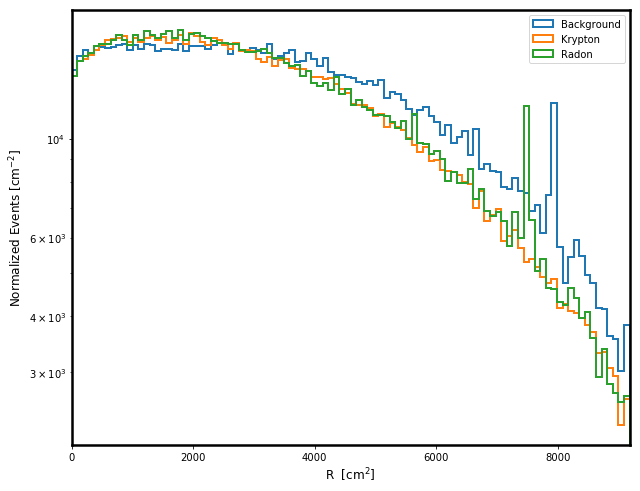

In [63]:
plt.figure(figsize=(10, 8))
for key, source in dfs_source_distrib_hist.items():
    alpha_array=source['alpha']
    r_norms=source['r_norms']
    print(key,len(alpha_array), len(r_norms))
    plt.hist(alpha_array[:, 0]**2, weights=1/r_norms, range=[0, (2*R_tpc)**2], bins=100, histtype='step', linewidth=2, label=key)
    #plt.vlines((R_tpc-rpos)**2, 0, 5000)
    #plt.vlines((R_tpc+rpos)**2, 0, 5000)
plt.yscale('log')
plt.xlim([0, (2*R_tpc)**2])
plt.ylabel('Normalized Events [cm$^{-2}$]', fontsize=12)
plt.xlabel('R  [cm$^{2}$]', fontsize=12)
plt.legend(loc='best')
#plt.savefig('fig_r2_norm_illustration_weighted.png')
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


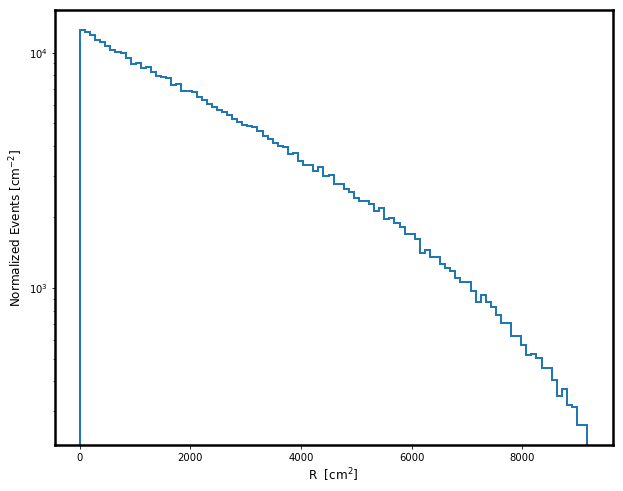

In [64]:
plt.figure(figsize=(10, 8))
plt.hist(alpha_array[:, 0]**2, range=[0, (2*R_tpc)**2], bins=100, histtype='step', linewidth=2)
#plt.vlines((R_tpc-rpos)**2, 0, 5000)
#plt.vlines((R_tpc+rpos)**2, 0, 5000)
#plt.ylim([0, 5000])
plt.yscale('log')
plt.ylabel('Normalized Events [cm$^{-2}$]', fontsize=12)
plt.xlabel('R  [cm$^{2}$]', fontsize=12)
#plt.savefig('fig_r2_norm_illustration.png')

plt.show()

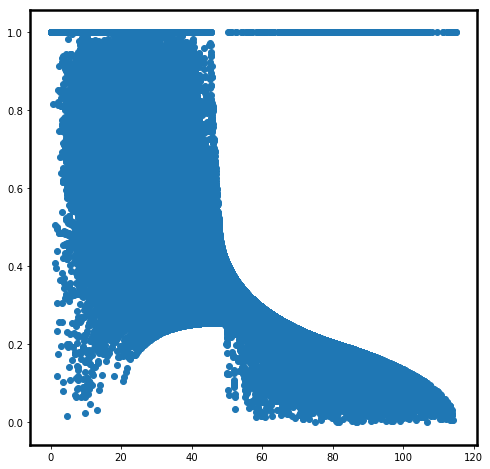

In [65]:
plt.figure(figsize=(8, 8))
plt.scatter(alpha_array[:, 0], r_norms)

### Search for Photo-Ionization events ###

In [ ]:
#plt.set_cmap('viridis')
plt.clf()
_xbins=np.linspace(700, 800, 100)
_ybins=np.linspace(0, 5, 100)
plt.figure(figsize=(30, 8))
numrows=1
numcols=2
gridspec.GridSpec(numrows, numcols)
index=0
for key, df in dict_datasets.items():
    print(key)
    plt.figure(figsize=(20, 8))
    
    #Time delay from S1
    plt.subplot2grid((numrows, numcols), (index, 0))
    plt.hist2d((df['drift_time']+df['time_since_s2'])/1000,       #us         
               df['se_range_50p_area']/1000,                      #us
               bins =[_xbins, _ybins], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('Time delay from main S1 [$\mu$s]')
    plt.ylabel('Peak Width [$\mu$s]')
    
    #Time delay from S2
    plt.subplot2grid((numrows, numcols), (index, 1))
    plt.plot(_xbins, cut_line(_xbins, 0.35, 0), color='r', linewidth=5)
    plt.hist2d((df['time_since_s2'])/1000,       #us         
               df['se_range_50p_area']/1000,                      #us
               bins =[_xbins, _ybins], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('Time delay from main S2 [$\mu$s]')
    plt.ylabel('Peak Width [$\mu$s]')
    
    plt.show()
#fig.tight_layout()
#fig.show()

In [ ]:
#Based on cuts from previous plot, select photo ionization events from gate
dict_gate_pi={}
for key, df in dict_datasets.items():
    df_gate_pi = hax.cuts.selection(df, df['se_range_50p_area']>cut_line(df['time_since_s2'], 0.35, 0), 'Cut Line')
    df_gate_pi = hax.cuts.range_selection(df_gate_pi, 'time_since_s2', [2500, 6000])
    dict_gate_pi[key]=df_gate_pi

In [ ]:
#plt.set_cmap('viridis')
plt.clf()
_xbins=np.linspace(0, 300000, 100)
_ybins=np.linspace(0, 30000, 100)
_relbins=np.linspace(0, 0.2, 100)
_driftbins=np.linspace(0, 50, 100)
_widthbins=np.linspace(0, 6, 100)
index=0
for key, df in dict_gate_pi.items():
    
    df = hax.cuts.selection(df, df['area']>1500, 'Peak Size Selection')
    
    print(key)
    numrows=1
    numcols=3
    fig=plt.figure(figsize=(10*numcols, 8*numrows))
    gridspec.GridSpec(numrows, numcols)
    
    #Relative Size compared to primary S2
    plt.subplot2grid((numrows, numcols), (index, 0))
    plt.hist2d((df['s2']),       #ep         
               df['area']/df['s2'],       #pe
               bins =[_xbins, _relbins], #norm=LogNorm(), vmin=1,
               )
    plt.colorbar()
    plt.xlabel('S2 [pe]')
    plt.ylabel('Peak Area/S2 Size')
    
    #Primary S2 compared to peak width
    plt.subplot2grid((numrows, numcols), (index, 1))
    plt.hist2d(df['s2'],       #ep         
               df['se_range_50p_area']/1000,       #pe
               bins =[_xbins, _widthbins], norm=LogNorm(), vmin=1,
               )
    plt.colorbar()
    plt.xlabel('S2 Size [pe]')
    plt.ylabel('Peak Width [$\mu$s]')
    
    #Drift time of event
    plt.subplot2grid((numrows, numcols), (index, 2))
    plt.hist2d(df['drift_time']/1000,       #ep         
               df['area'],       #pe
               bins =[_driftbins, _ybins], norm=LogNorm(), vmin=1,
               )
    plt.colorbar()
    plt.xlabel('Drift_Time [$\mu$s]')
    plt.ylabel('Peak Area [pe]')
    
    ax1=plt.gca()
    ax2=ax1.twinx()
    ax2.hist(df['drift_time']/1000, bins=_driftbins, color='r', histtype='step', linewidth=3, log=True)
    ax2.set_ylabel('Counts', color = 'r')
    ax2.tick_params(axis='y', colors='r')

 
    
    plt.show()
fig.tight_layout()
#fig.show()

In [ ]:
plt.clf()
_xbins=np.linspace(-50, 50, 100)
_ybins=np.linspace(-50, 50, 100)
_channelbins=np.linspace(0, 100, 101)
for key, df in dict_gate_pi.items():
    
    df = hax.cuts.selection(df, df['area']>1500, 'Peak Size Selection')
    
    print(key)
    numrows=1
    numcols=2
    fig=plt.figure(figsize=(10*numcols, 8*numrows))
    gridspec.GridSpec(numrows, numcols)
    
    #X-Y Distribution
    plt.subplot2grid((numrows, numcols), (index, 0))
    plt.hist2d((df['x_se']),       #ep         
               df['y_se'],       #pe
               bins =[_xbins, _ybins], norm=LogNorm(), vmin=1,
               )
    plt.colorbar()
    plt.xlabel('X [cm]')
    plt.ylabel('Y [cm]')
    
    
    #N Channels
    plt.subplot2grid((numrows, numcols), (index, 1))
    plt.hist(df['n_contributing_channels'],
               bins=_channelbins
               )
    plt.colorbar()
    plt.xlabel('Channels [#]')
    plt.ylabel('Counts [#]')
    
   
    plt.show()
fig.tight_layout()
#fig.show()

In [ ]:
%%time
# Determine number of waveforms in each data sample
for key, df in dict_gate_pi.items():
    df = hax.cuts.selection(df, df['area']>1500, 'Peak Size Selection')
    files = df['run_number'].unique()
    count = 0
    for run in files:
        df_run= df.loc[df['run_number']==run]
        count+=len(df_run['event_number'].unique())
    print(key, count)

### Look at Width of Peaks ###

In [ ]:
plt.set_cmap('viridis')
plt.figure(figsize=(30, 8))
#numrows=3
#numcols=1
#gridspec.GridSpec(numrows, numcols)
#index=0
for key, dataset in datasets.items():
    print(key)
    plt.figure(figsize=(10, 8))
    #plt.subplot2grid((numrows, numcols), (index, 0))
    #dataset = hax.cuts.selection(data_radon_sr1,  data_radon_sr1['n_hits']<100, 'SE Selection')
    plt.hist2d(dataset['drift_time'], dataset['s2_range_50p_area'], bins =[100, 100], range=[[0, 750000], [0, 2500]], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('S2 Drift Time [$\mu$s]')
    plt.ylabel('S2 Width [ns]')
    plt.show()
#fig.tight_layout()
#fig.show()

In [ ]:
def cut_line(x, m, c):
    return m*x+c

In [ ]:
#plt.set_cmap('viridis')
for key, dataset in datasets.items():
    print(key)
    plt.figure(figsize=(10, 8))
    x_hits = np.linspace(0, 15000, 100)
    plt.plot(x_hits, cut_line(x_hits, 2, -1000), color='r', linewidth=5)
    #plt.plot(x_hits, cut_line(x_hits, 0.3, -200), color='g', linewidth=5)
    plt.hist2d(dataset['n_hits'], dataset['se_range_50p_area'], bins =[100, 100], range=[[0, 20000], [0, 10000]], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('Hits')
    plt.ylabel('SE Width [ns]')
    plt.savefig('All_peaks_line.png')
    plt.show()

In [ ]:
datasets_hits_small={}
datasets_hits_large={}
for key, dataset in datasets.items():
    print(key)
    dataset_small=hax.cuts.selection(dataset, dataset['se_range_50p_area']<cut_line(dataset['n_hits'], 2, -1000), 'n_hits Selection small')
    dataset_large=hax.cuts.selection(dataset, dataset['se_range_50p_area']>cut_line(dataset['n_hits'], 2, -1000), 'n_hits Selection large')
    datasets_hits_small.update({key:dataset_small})
    datasets_hits_large.update({key:dataset_large})

In [ ]:
for key, dataset in datasets_hits_small.items():
    print(key)
    plt.figure(figsize=(10, 8))
    #dataset = hax.cuts.selection(data_radon_sr1,  data_radon_sr1['n_hits']<100, 'SE Selection')
    plt.hist2d(dataset['drift_time']+dataset['time_since_s2'], dataset['se_range_50p_area'], bins =[100, 100], range=[[0, 2000000], [0, 5000]], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('SE Drift Time [ns]')
    plt.ylabel('SE Width [ns]')
    plt.savefig('Large_n_hits.png')
    plt.show()

In [ ]:
len(data_bkg.event_number.unique())

In [ ]:
len(datasets_hits_small['bkg'])

In [ ]:
datasets_tmp={}
for key, dataset in datasets_hits_small.items():
    print(key)
    dataset_tmp=hax.cuts.selection(dataset, dataset['type']=='s2', 'S2 Selection')
    dataset_tmp=hax.cuts.selection(dataset, dataset['drift_time']+dataset['time_since_s2']<745000, 'Drift not in TPC')
    datasets_tmp.update({key:dataset_tmp})

In [ ]:
for key, dataset in datasets_tmp1.items():
    print(key)
    plt.figure(figsize=(10, 8))
    #dataset = hax.cuts.selection(data_radon_sr1,  data_radon_sr1['n_hits']<100, 'SE Selection')
    plt.hist2d(dataset['r_s2']**2, dataset['time_since_s2'], bins=[100, 100], range=[[0, 50**2], [0, 400000]], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('R^2 S2  [cm^2]')
    plt.ylabel('Time Since S2 [ns]')
    #plt.savefig('Large_n_hits.png')
    plt.show()

In [ ]:
for key, dataset in datasets_tmp1.items():
    print(key)
    plt.figure(figsize=(10, 8))
    #dataset = hax.cuts.selection(data_radon_sr1,  data_radon_sr1['n_hits']<100, 'SE Selection')
    plt.hist2d(dataset['x_s2'], dataset['y_s2'], bins=[100, 100], range=[[-55, 55], [-55, 55]], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('X [cm]')
    plt.ylabel('Y [cm]')
    #plt.savefig('Large_n_hits.png')
    plt.show()

In [ ]:
%%capture
for key, dataset in datasets_tmp.items():
    xspace=np.linspace(-50, 50, 21)
    yspace=np.linspace(-50, 50, 21)
    xbins = xspace[:-1]+(xspace[1:]-xspace[:-1])/2
    ybins = yspace[:-1]+(yspace[1:]-yspace[:-1])/2
    x_pos=[]
    y_pos=[]
    x_disp=[]
    y_disp=[]
    color_scale=[]
    for x_index in range(len(xspace)-1):
        data_slice_x = hax.cuts.selection(dataset, dataset['x_s2']>xspace[x_index], 'X LowerBound')
        data_slice_x = hax.cuts.selection(data_slice_x, data_slice_x['x_s2']<xspace[x_index+1], 'X UpperBound')
        #x_series=[]
        #y_series=[]
        x_ave=[]
        y_ave=[]
        for y_index in range(len(yspace)-1):
            print(x_index, y_index)
            data_slice_y = hax.cuts.selection(data_slice_x, data_slice_x['y_s2']>yspace[y_index], 'Y LowerBound')
            data_slice_y = hax.cuts.selection(data_slice_y, data_slice_y['y_s2']<yspace[y_index+1], 'Y UpperBound')

            x_vector = data_slice_y.x_se - data_slice_y.x_s2
            y_vector = data_slice_y.y_se - data_slice_y.y_s2
            rad_disp = data_slice_y.r_se - data_slice_y.r_s2
            color_scale.append(np.mean(rad_disp))
            x_disp.append(np.mean(x_vector))
            y_disp.append(np.mean(y_vector))
            x_pos.append(xbins[x_index])
            y_pos.append(ybins[y_index])


In [ ]:
print(len(x_pos))
plt.figure(figsize=(10, 10))
#    color_scale=dataset.r_se-dataset.r_s2
Q=plt.quiver(x_pos, y_pos, x_disp, y_disp, color_scale, units='x', pivot='tail', angles='xy', scale_units='xy', scale=1)
cb=plt.colorbar(Q)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.savefig('Rad_disp.png')
plt.show()

In [ ]:
for key, dataset in datasets_hits_large.items():
    print(key)
    plt.figure(figsize=(10, 8))
    #dataset = hax.cuts.selection(data_radon_sr1,  data_radon_sr1['n_hits']<100, 'SE Selection')
    plt.hist2d(dataset['time_since_s2'], dataset['se_range_50p_area'], bins =[100, 100], range=[[0, 3000000], [0, 50000]], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('Time Since S2 [ns]')
    plt.ylabel('SE Width [ns]')
    #plt.savefig('Large_n_hits.png')
    plt.show()

In [ ]:
datasets_tmp4={}
for key, dataset in datasets_hits_large.items():
    print(key)
    dataset_tmp=hax.cuts.selection(dataset, dataset['type']=='s2', 'S2 Selection')
    dataset_tmp=hax.cuts.selection(dataset, dataset['time_since_s2']>745000, 'Drift not in TPC')
    datasets_tmp4.update({key:dataset_tmp})

In [ ]:
for key, dataset in datasets_tmp4.items():
    print(key)
    plt.figure(figsize=(10, 8))
    #dataset = hax.cuts.selection(data_radon_sr1,  data_radon_sr1['n_hits']<100, 'SE Selection')
    plt.hist2d(dataset['x_se'], dataset['y_se'], bins=[100, 100], range=[[-50, 50], [-50, 50]], norm=LogNorm(), vmin=1)
    plt.colorbar()
    plt.xlabel('R^2 S2  [cm^2]')
    plt.ylabel('Time Since S2 [ns]')
    #plt.savefig('Large_n_hits.png')
    plt.show()

In [ ]:
%%capture
for key, dataset in datasets_tmp4.items():
    xspace=np.linspace(-50, 50, 21)
    yspace=np.linspace(-50, 50, 21)
    xbins = xspace[:-1]+(xspace[1:]-xspace[:-1])/2
    ybins = yspace[:-1]+(yspace[1:]-yspace[:-1])/2
    x_pos=[]
    y_pos=[]
    x_disp=[]
    y_disp=[]
    color_scale=[]
    for x_index in range(len(xspace)-1):
        data_slice_x = hax.cuts.selection(dataset, dataset['x_s2']>xspace[x_index], 'X LowerBound')
        data_slice_x = hax.cuts.selection(data_slice_x, data_slice_x['x_s2']<xspace[x_index+1], 'X UpperBound')
        #x_series=[]
        #y_series=[]
        x_ave=[]
        y_ave=[]
        for y_index in range(len(yspace)-1):
            print(x_index, y_index)
            data_slice_y = hax.cuts.selection(data_slice_x, data_slice_x['y_s2']>yspace[y_index], 'Y LowerBound')
            data_slice_y = hax.cuts.selection(data_slice_y, data_slice_y['y_s2']<yspace[y_index+1], 'Y UpperBound')

            x_vector = data_slice_y.x_se - data_slice_y.x_s2
            y_vector = data_slice_y.y_se - data_slice_y.y_s2
            rad_disp = data_slice_y.r_se - data_slice_y.r_s2
            color_scale.append(np.mean(rad_disp))
            x_disp.append(np.mean(x_vector))
            y_disp.append(np.mean(y_vector))
            x_pos.append(xbins[x_index])
            y_pos.append(ybins[y_index])


In [ ]:
print(len(x_pos))
plt.figure(figsize=(10, 10))
#    color_scale=dataset.r_se-dataset.r_s2
Q=plt.quiver(x_pos, y_pos, x_disp, y_disp, color_scale, units='x', pivot='tail', angles='xy', scale_units='xy', scale=1)
cb=plt.colorbar(Q)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

In [ ]:
#plt.set_cmap('viridis')
plt.figure(figsize=(10, 8))
dataset_below = hax.cuts.selection(dataset,  dataset['se_range_50p_area']<500, 'SE Width Population')
(bins_below, dump, d) = plt.hist(dataset_below['time_since_s2'], bins =100, range=[0, 6000000])
plt.yscale('log')

plt.show()

In [ ]:
#plt.set_cmap('viridis')
plt.figure(figsize=(10, 8))
dataset_above = hax.cuts.selection(dataset,  dataset['se_range_50p_area']>500, 'SE Width Population')
(bins_above, dump, d)=plt.hist(dataset_above['time_since_s2'], bins =100, range=[0, 6000000])
plt.yscale('log')

plt.show()

In [ ]:
#bins_above/bins_below
plt.plot(dump[:-1], bins_above/bins_below)
plt.show()

In [ ]:
#plt.set_cmap('viridis')
plt.figure(figsize=(10, 8))
dataset_tmp = hax.cuts.range_selection(dataset_below, 'x_s2', [-17, -13])
dataset_tmp = hax.cuts.range_selection(dataset_tmp, 'y_s2', [-17, -13])
plt.hist2d(dataset_tmp['x_se'], dataset_tmp['y_se'], bins =[100, 100], range=[[-50, 50], [-50, 50]], norm=LogNorm(), vmin=1)
plt.colorbar()
plt.show()

In [ ]:
#plt.set_cmap('viridis')
plt.figure(figsize=(10, 8))
dataset_tmp = hax.cuts.range_selection(dataset_above, 'x_s2', [-17, -13])
dataset_tmp = hax.cuts.range_selection(dataset_tmp, 'y_s2', [-17, -13])
plt.hist2d(dataset_tmp['x_se'], dataset_tmp['y_se'], bins =[100, 100], range=[[-50, 50], [-50, 50]], norm=LogNorm(), vmin=1)
plt.colorbar()
plt.show()

In [ ]:
#plt.set_cmap('viridis')
plt.figure(figsize=(10, 8))
plt.hist2d(dataset['r_s2']**2, -dataset['drift_time'], bins =[100, 100], range=[[0, 40**2], [-650000, 0]], norm=LogNorm(), vmin=1)
plt.colorbar()
plt.show()

In [ ]:
#%%capture
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
data_se=dataset
data_se=hax.cuts.selection(data_se, data_se['r_s2']<20, 'RadialSelection')
a_means=[]
b_means=[]
a_means_error=[]
b_means_error=[]

time_series = np.linspace(0, 2000000, 15)
for index in range(len(time_series[:-1])):

    data_slice = hax.cuts.selection(data_se, data_se['time_since_s2']>time_series[index], 'LowerBound')
    data_slice = hax.cuts.selection(data_slice, data_slice['time_since_s2']<time_series[index+1], 'UpperBound')

    _bins=100
    _r_lower=-50
    _r_upper=50
    _r_range=[_r_lower, _r_upper]
    plt.set_cmap("viridis")
    content =plt.hist(data_slice.r_se-data_slice.r_s2, bins=_bins, range=_r_range)

    x=content[1][:-1]+(content[1][1:]-content[1][:-1])/2 #bin_centers
    y=content[0] #bin_content

    def gaus(x, a, xa, sigma_a, b, xb, sigma_b):
        return a*exp(-(x-xa)**2/(2*sigma_a**2))+b*exp(-(x-xb)**2/(2*sigma_b**2))

    initial_values = [40000, 4, 4, 50000, 22, 12]

    popt,pcov = curve_fit(gaus,x,y,p0=initial_values)
    print("Amplitude a: %.4f+/-%.4f" %(popt[0],pcov[0][0]))
    print("Mean a: %.4f+/-%.4f" %(popt[1],pcov[1][1]))
    a_means.append(popt[1])
    a_means_error.append(pcov[1][1])
    print("Sigma a: %.4f+/-%.4f" %(popt[2],pcov[2][2]))
    print("Amplitude b: %.4f+/-%.4f" %(popt[3],pcov[3][3]))
    print("Mean b: %.4f+/-%.4f" %(popt[4],pcov[4][4]))
    b_means.append(popt[4])
    b_means_error.append(pcov[4][4])    
    print("Sigma b: %.4f+/-%.4f" %(popt[5],pcov[5][5]))

    
    plt.title("%i ns < Time Delay < %i ns" %(time_series[index], time_series[index+1]))
    plt.plot(x,gaus(x,*popt),'ro:')
    plt.xlabel('Radial Displacement [cm]')
    plt.ylabel('Counts')
    #plt.savefig('radial_displacement_%i.pdf' %index)
    #plt.savefig('radial_displacement_%i.png' %index)
    plt.legend()
    plt.show()


In [ ]:
plt.errorbar(time_series[:-1]/1000, a_means[0:], yerr=a_means_error[0:], color='b', label='SR0', ecolor='b', fmt='s')
#plt.errorbar(time_series[:-1]/1000, b_means_sr1[0:], yerr=b_means_error_sr1[0:], color='r', label='SR0', ecolor='r', fmt='s')
#plt.errorbar(time_series[:-1]/1000, a_means_sr1[0:], yerr=a_means_error_sr1[0:], color='r', label='SR1', ecolor='r', fmt='o')
#plt.errorbar(time_series[1:-1], b_means[1:], yerr=b_means_error[1:], color='b', label='Higher Distribution')
plt.ylim(0, 16)
#plt.xlim(550, 2000)
plt.ylabel('Radial Displacement [cm]')
plt.xlabel('Time Delay [$\mu$s]')
axes=plt.gca()
axes.ticklabel_format(axis='x', style='sci')
plt.savefig('time_delay_displacement.pdf')
plt.savefig('time_delay_displacement.png')
#plt.legend(loc='best')

### Select S2s in small volume. Look at displacement of SEs following ###

In [ ]:
def gauss_2d(data_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta):
    (x, y) = data_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()


In [ ]:
def double_gauss_2d(data_tuple, amp_0, xo, yo, sigma_x0, sigma_y0, theta_0, amp_1, x1, y1, sigma_x1, sigma_y1, theta_1):
    (x, y) = data_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta_0)**2)/(2*sigma_x0**2) + (np.sin(theta_0)**2)/(2*sigma_y0**2)
    b = -(np.sin(2*theta_0))/(4*sigma_x0**2) + (np.sin(2*theta_0))/(4*sigma_y0**2)
    c = (np.sin(theta_0)**2)/(2*sigma_x0**2) + (np.cos(theta_0)**2)/(2*sigma_y0**2)
    d = (np.cos(theta_1)**2)/(2*sigma_x1**2) + (np.sin(theta_1)**2)/(2*sigma_y1**2)
    e = -(np.sin(2*theta_1))/(4*sigma_x1**2) + (np.sin(2*theta_1))/(4*sigma_y1**2)
    f = (np.sin(theta_1)**2)/(2*sigma_x1**2) + (np.cos(theta_1)**2)/(2*sigma_y1**2)
    g = amp_0*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2))) 
    + amp_1*np.exp( - (d*((x-x1)**2) + 2*e*(x-x1)*(y-y1) + f*((y-y1)**2)))
    return g.ravel()


In [ ]:
from scipy.optimize import curve_fit

def fit_gauss_2d(initial_guess, counts, xedges, yedges):
    xcenters = xedges[:-1]+(xedges[1:]-xedges[:-1])/2
    ycenters = yedges[:-1]+(yedges[1:]-yedges[:-1])/2
    x_bins, y_bins = np.meshgrid(xcenters, ycenters)
    try:
        popt, pcov = curve_fit(gauss_2d, (x_bins, y_bins), counts.ravel(), p0=initial_guess, maxfev=2500)
        counts_fitted = gauss_2d((x_bins, y_bins), *popt)
        plt.contour(y_bins, x_bins, counts_fitted.reshape(_xbins, _ybins), 3, colors='w')
        return [popt[1], popt[2], pcov[1][1], pcov[2][2]]
    except RuntimeError:
        return [-100, -100, 0, 0] 

    #print("Amplitude A: %.4f+/-%.4f" %(popt[0],pcov[0][0]))
    #print("Y Mean: %.4f+/-%.4f" %(popt[1],pcov[1][1]))
    #print("Y Sigma: %.4f+/-%.4f" %(popt[3],pcov[3][3]))
    #print("X Mean: %.4f+/-%.4f" %(popt[2],pcov[2][2]))
    #print("X Sigma: %.4f+/-%.4f" %(popt[4],pcov[4][4]))
    
    return [popt[1], popt[2], pcov[1][1], pcov[2][2]]

In [ ]:
from scipy.optimize import curve_fit

def fit_double_gauss_2d(initial_guess, counts, xedges, yedges):
    xcenters = xedges[:-1]+(xedges[1:]-xedges[:-1])/2
    ycenters = yedges[:-1]+(yedges[1:]-yedges[:-1])/2
    x_bins, y_bins = np.meshgrid(xcenters, ycenters)
    try:
        popt, pcov = curve_fit(double_gauss_2d, (x_bins, y_bins), counts.ravel(), p0=initial_guess, maxfev=2500)
        counts_fitted_0 = gauss_2d((x_bins, y_bins), *popt[:6])
        counts_fitted_1 = gauss_2d((x_bins, y_bins), *popt[6:])
        plt.contour(y_bins, x_bins, counts_fitted_0.reshape(_xbins, _ybins), 3, colors='w')
        plt.contour(y_bins, x_bins, counts_fitted_1.reshape(_xbins, _ybins), 3, colors='r')
        
        print("Y0 Mean: %.4f+/-%.4f" %(popt[1],pcov[1][1]))
        print("Y1 Mean: %.4f+/-%.4f" %(popt[7],pcov[7][7]))
        print("X0 Mean: %.4f+/-%.4f" %(popt[2],pcov[2][2]))
        print("X1 Mean: %.4f+/-%.4f" %(popt[8],pcov[8][8]))
        
        return [popt[1], popt[2], popt[7], popt[8]]
    except RuntimeError:
        return [-100, -100, -100, -100] 


In [ ]:
_xpoint = 10
_ypoint = 10
_width = 4
_xbins=40
_ybins=40
_x_lower=-50
_x_upper=50
_x_range=[_x_lower, _x_upper]
_y_lower=-50
_y_upper=50
_y_range=[_y_lower, _y_upper]
means=[]
data_xy = hax.cuts.range_selections(data_radon, ('x_s2', (_xpoint-_width/2, _xpoint+_width/2)),
                                    ('y_s2', (_ypoint-_width/2, _ypoint+_width/2)))

time_series = np.linspace(750000, 1750000, 9)
for index in range(len(time_series[:-1])):
    initial_guess=(10,-5,-5,5,5,0,10,15,15,5,5,0)
    
    data_slice=hax.cuts.range_selection(data_xy, 'time_since_s2', (time_series[index], time_series[index+1]))
    (counts, xedges, yedges, Image)=plt.hist2d(data_slice.x_se, data_slice.y_se, bins=[_xbins, _ybins], norm=LogNorm(), range=[_x_range, _y_range], vmin=1)
    plt.colorbar()
    fitvalues=fit_double_gauss_2d(initial_guess, counts, xedges, yedges)
    means.append(fitvalues)
    means_arr=np.array(means)
    means_flat=means_arr.ravel()
    #plt.xlabel('Electrons') 
    #plt.ylabel('Photons')
    #plt.savefig('confined_xy_%i.pdf' %index)
    #plt.savefig('confined_xy_%i.png' %index)
    #plt.legend()
    plt.show()

In [ ]:
%%capture
_xpoints = np.linspace(-10, 10, 6)
_ypoints = np.linspace(-10, 10, 6)

time_series = [0, 250000, 750000, 1250000, 1500000, 175000]
_width = 3
_xbins=40
_ybins=40
_x_lower=-50
_x_upper=50
_x_range=[_x_lower, _x_upper]
_y_lower=-50
_y_upper=50
_y_range=[_y_lower, _y_upper]
x_pos1=[]
y_pos1=[]

x_disp=[]
y_disp=[]
for _xpoint in _xpoints:
    for _ypoint in _ypoints:
        print(_xpoint, _ypoint)
        data_xy = hax.cuts.range_selections(data_radon, ('x_s2', (_xpoint-_width/2, _xpoint+_width/2)),
                                            ('y_s2', (_ypoint-_width/2, _ypoint+_width/2)))

        means=[]
        #time_series = np.linspace(700000, 2000000,5)
        for index in range(len(time_series[:-1])):
            initial_guess=(10,_xpoint,_ypoint,5,5,0, 10)

            data_slice=hax.cuts.range_selection(data_xy, 'time_since_s2', (time_series[index], time_series[index+1]))
            (counts, xedges, yedges, Image)=plt.hist2d(data_slice.x_se, data_slice.y_se, bins=[_xbins, _xbins], range=[_x_range, _y_range], norm=LogNorm(), vmin=1)
            #plt.colorbar()
            fitvalues=fit_gauss_2d(initial_guess, counts, xedges, yedges)
            means.append(fitvalues)
        means_arr=np.array(means)
        means_flat=means_arr.ravel()
        if means_flat[0]==-100 or means_flat[8]==-100:
            x_pos.append(0)
            y_pos.append(0)
            x_disp.append(0)
            y_disp.append(0)
        else:
            y_pos.append(means_flat[0])
            x_pos.append(means_flat[1])
            y_disp.append(means_flat[8]-means_flat[0])
            x_disp.append(means_flat[9]-means_flat[1])
            index+=1


In [ ]:
plt.figure(figsize=(10, 10))
Q=plt.quiver(x_pos, y_pos, x_disp, y_disp)  
plt.xlim(-15, 15)
plt.ylim(-15, 15)

In [ ]:
means_arr=np.array(means)
means_flat=means_arr.ravel()
time_axis=time_series[:-1]+(time_series[1:]-time_series[:-1])/2
plt.plot(time_axis/1000, means_flat[::4],  label='X0 Position', marker='o')
plt.plot(time_axis/1000, means_flat[1::4],  label='Y1 Position', marker = 's')
plt.legend(loc='best')

In [ ]:
means_flat[::4]

In [ ]:
means_arr=np.array(means)
means_flat=means_arr.ravel()
time_axis=time_series[:-1]+(time_series[1:]-time_series[:-1])/2
plt.errorbar(time_axis[1:]/1000, means_flat[5::4], yerr=means_flat[7::4], label='X Position')
plt.errorbar(time_axis[1:]/1000, means_flat[4::4], yerr=means_flat[6::4], label='Y Position')
plt.legend(loc='best')

In [ ]:
means_arr=np.array(means1)
means_flat=means_arr.ravel()
time_axis=time_series[:-1]+(time_series[1:]-time_series[:-1])/2
plt.errorbar(time_axis[1:]/1000, means_flat[5::4], yerr=means_flat[7::4], label='X Position')
#plt.errorbar(time_axis[1:]/1000, means_flat[4::4], yerr=means_flat[6::4], label='Y Position')
plt.legend(loc='best')

In [ ]:
#10, 0, time 700, 1800
means1=means_arr

In [ ]:
#5, 0
means2=means_arr

### Next Step ###

Kyk na delta theta

### Off Set of SEs ###

In [ ]:
datasets = {'SR0' : data_radon_sr0, 'SR1': data_radon_sr1}

In [ ]:
datasets_se={}
for key, dataset in datasets.items():
    data_se = hax.cuts.selection(dataset, dataset['r_s2']<20, 'Radial')
    data_se = hax.cuts.selection(dataset, dataset['n_hits']<36, 'SE Selection')
    datasets_se.update({key:data_se})

In [ ]:
_bins=100
_x_lower=-50
_x_upper=50
_x_range=[_x_lower, _x_upper]
_y_lower=-50
_y_upper=50
_y_range=[_y_lower, _y_upper]
#fig = plt.figure(figsize=(10, 8))
plt.set_cmap("viridis")
plt.hist2d(data_se.x_se, data_se.y_se, bins=[_bins, _bins], range=[_x_range, _y_range], norm=LogNorm(), vmin=1)
plt.colorbar()
#plt.xlabel('Electrons') 
#plt.ylabel('Photons')

In [ ]:
_bins=100
_r_lower=0
_r_upper=50
_el_range=[_r_lower, _r_upper]
_t_lower=0
_t_upper=4000000
_ph_range=[_t_lower, _t_upper]
fig = plt.figure(figsize=(10, 8))
plt.set_cmap("viridis")
plt.hist2d(data_se.dist_to_s2, data_se.time_since_s2, bins=[_bins, _bins], range=[_el_range, _ph_range], norm =LogNorm(), vmin=1)
plt.colorbar()
#plt.xlabel('Electrons') 
#plt.ylabel('Photons')

In [ ]:
%%capture
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
data_se=datasets_se['SR1']
a_means=[]
b_means=[]
a_means_error=[]
b_means_error=[]

time_series = np.linspace(0, 2000000, 19)
for index in range(len(time_series[:-1])):

    data_slice = hax.cuts.selection(data_se, data_se['time_since_s2']>time_series[index], 'LowerBound')
    data_slice = hax.cuts.selection(data_slice, data_slice['time_since_s2']<time_series[index+1], 'UpperBound')

    _bins=100
    _r_lower=-50
    _r_upper=50
    _r_range=[_r_lower, _r_upper]
    plt.set_cmap("viridis")
    content =plt.hist(data_slice.r_se-data_slice.r_s2, bins=_bins, range=_r_range)

    x=content[1][:-1]+(content[1][1:]-content[1][:-1])/2 #bin_centers
    y=content[0] #bin_content

    def gaus(x, a, xa, sigma_a, b, xb, sigma_b):
        return a*exp(-(x-xa)**2/(2*sigma_a**2))+b*exp(-(x-xb)**2/(2*sigma_b**2))

    initial_values = [40000, 4, 4, 50000, 22, 12]

    popt,pcov = curve_fit(gaus,x,y,p0=initial_values)
    print("Amplitude a: %.4f+/-%.4f" %(popt[0],pcov[0][0]))
    print("Mean a: %.4f+/-%.4f" %(popt[1],pcov[1][1]))
    a_means.append(popt[1])
    a_means_error.append(pcov[1][1])
    print("Sigma a: %.4f+/-%.4f" %(popt[2],pcov[2][2]))
    print("Amplitude b: %.4f+/-%.4f" %(popt[3],pcov[3][3]))
    print("Mean b: %.4f+/-%.4f" %(popt[4],pcov[4][4]))
    b_means.append(popt[4])
    b_means_error.append(pcov[4][4])    
    print("Sigma b: %.4f+/-%.4f" %(popt[5],pcov[5][5]))

    
    plt.title("%i ns < Time Delay < %i ns" %(time_series[index], time_series[index+1]))
    plt.plot(x,gaus(x,*popt),'ro:')
    plt.xlabel('Radial Displacement [cm]')
    plt.ylabel('Counts')
    #plt.savefig('radial_displacement_%i.pdf' %index)
    #plt.savefig('radial_displacement_%i.png' %index)
    plt.legend()
    plt.show()


In [ ]:
a_means_sr1=a_means
a_means_error_sr1=a_means_error

In [ ]:
a_means_sr0=a_means
a_means_error_sr0=a_means_error
b_means_sr0=b_means
b_means_error_sr0=b_means_error

In [ ]:
plt.errorbar(time_series[:-1]/1000, a_means_sr1[0:], yerr=a_means_error_sr1[0:], color='b', label='SR0', ecolor='b', fmt='s')
#plt.errorbar(time_series[:-1]/1000, b_means_sr1[0:], yerr=b_means_error_sr1[0:], color='r', label='SR0', ecolor='r', fmt='s')
#plt.errorbar(time_series[:-1]/1000, a_means_sr1[0:], yerr=a_means_error_sr1[0:], color='r', label='SR1', ecolor='r', fmt='o')
#plt.errorbar(time_series[1:-1], b_means[1:], yerr=b_means_error[1:], color='b', label='Higher Distribution')
plt.ylim(0, 16)
#plt.xlim(550, 2000)
plt.ylabel('Radial Displacement [cm]')
plt.xlabel('Time Delay [$\mu$s]')
axes=plt.gca()
axes.ticklabel_format(axis='x', style='sci')
plt.savefig('time_delay_displacement.pdf')
plt.savefig('time_delay_displacement.png')
#plt.legend(loc='best')

In [ ]:
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

c_means=[]
d_means=[]
c_means_error=[]
d_means_error=[]

time_series = np.linspace(1800000, 1900000, 2)
for index in range(len(time_series[:-1])):

    data_slice = hax.cuts.selection(data_se, data_se['time_since_s2']>time_series[index], 'LowerBound')
    data_slice = hax.cuts.selection(data_slice, data_slice['time_since_s2']<time_series[index+1], 'UpperBound')

    _bins=100
    _r_lower=-50
    _r_upper=50
    _r_range=[_r_lower, _r_upper]
    plt.set_cmap("viridis")
    content =plt.hist(data_slice.r_se-data_slice.r_s2, bins=_bins, range=_r_range)

    x=content[1][:-1]+(content[1][1:]-content[1][:-1])/2 #bin_centers
    y=content[0] #bin_content

    def gaus(x, a, xa, sigma_a, b, xb, sigma_b):
        return a*exp(-(x-xa)**2/(2*sigma_a**2))+b*exp(-(x-xb)**2/(2*sigma_b**2))

    initial_values = [4000, 4, 4, 3000, 29, 12]

    popt,pcov = curve_fit(gaus,x,y,p0=initial_values)
    print("Amplitude a: %.4f+/-%.4f" %(popt[0],pcov[0][0]))
    print("Mean a: %.4f+/-%.4f" %(popt[1],pcov[1][1]))
    c_means.append(popt[1])
    c_means_error.append(pcov[1][1])
    print("Sigma a: %.4f+/-%.4f" %(popt[2],pcov[2][2]))
    print("Amplitude b: %.4f+/-%.4f" %(popt[3],pcov[3][3]))
    print("Mean b: %.4f+/-%.4f" %(popt[4],pcov[4][4]))
    d_means.append(popt[4])
    d_means_error.append(pcov[4][4])    
    print("Sigma b: %.4f+/-%.4f" %(popt[5],pcov[5][5]))

    
    plt.title("%i ns < Time Delay < %i ns" %(time_series[index], time_series[index+1]))
    plt.plot(x,gaus(x,*popt),'ro:')
    plt.xlabel('Radial Displacement [cm]')
    plt.ylabel('Counts')
    #plt.savefig('radial_displacement_%i.pdf' %index)
    #plt.savefig('radial_displacement_%i.png' %index)
    plt.legend()
    plt.show()


In [ ]:
#%%capture
xspace=np.linspace(-20, 20, 21)
yspace=np.linspace(-20, 20, 21)
x_means=[]
y_means=[]
x_pos=[]
y_pos=[]
for x_index in range(len(xspace)-1):
    data_slice_x = hax.cuts.selection(data_se, data_se['x_s2']>xspace[x_index], 'X LowerBound')
    data_slice_x = hax.cuts.selection(data_slice_x, data_slice_x['x_s2']<xspace[x_index+1], 'X UpperBound')
    x_series=[]
    y_series=[]
    x_ave=[]
    y_ave=[]
    for y_index in range(len(yspace)-1):
        print(x_index, y_index)
        data_slice_y = hax.cuts.selection(data_slice_x, data_slice_x['y_s2']>yspace[y_index], 'Y LowerBound')
        data_slice_y = hax.cuts.selection(data_slice_y, data_slice_y['y_s2']<yspace[y_index+1], 'Y UpperBound')

        x_vector = data_slice_y.x_se - data_slice_y.x_s2
        y_vector = data_slice_y.y_se - data_slice_y.y_s2
        x_ave.append(np.mean(x_vector))
        y_ave.append(np.mean(y_vector))
        x_series.append(xspace[x_index]+(xspace[x_index+1]-xspace[x_index])/2)
        y_series.append(yspace[y_index]+(yspace[y_index+1]-yspace[y_index])/2)
        #print(x_index, y_index, x_ave, y_ave)
    x_pos.append(x_series)
    y_pos.append(y_series)
    x_means.append(x_ave)
    y_means.append(y_ave)


In [ ]:
plt.figure(figsize=(5.7, 5.7))
U=np.cos(x_means)
V=np.sin(y_means)
Q=plt.quiver(x_pos, y_pos, U, V)
plt.ylabel('Y Displacement [cm]')
plt.xlabel('X Displacement [cm]')
plt.savefig('average_displacement.pdf')
plt.savefig('average_displacement.png')
plt.show()

In [ ]:
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

a_means=[]
b_means=[]
a_means_error=[]
b_means_error=[]

time_series = np.linspace(0, 2000000, 51)
for index in range(len(time_series[:-1])):
    
    data_se = hax.cuts.selection(data_radon, data_radon['r_s2']<1, 'X-y selection')
    data_slice = hax.cuts.selection(data_se, data_se['time_since_s2']>time_series[index], 'LowerBound')
    data_slice = hax.cuts.selection(data_slice, data_slice['time_since_s2']<time_series[index+1], 'UpperBound')

    _bins=100
    _x_lower=-50
    _x_upper=50
    _x_range=[_x_lower, _x_upper]
    _y_lower=-50
    _y_upper=50
    _y_range=[_y_lower, _y_upper]
    #fig = plt.figure(figsize=(10, 8))
    plt.set_cmap("viridis")
    plt.hist2d(data_se.x_se, data_se.y_se, bins=[_bins, _bins], range=[_x_range, _y_range], norm=LogNorm(), vmin=1)
    plt.colorbar()
    #plt.xlabel('Electrons') 
    #plt.ylabel('Photons')
    plt.savefig('confined_xy_%i.pdf' %index)
    plt.savefig('confined_xy_%i.png' %index)
    plt.legend()
    plt.show()
